# Simple tile 2 zarr creation using centre positions

**NOTE**: All tiltes have same dimentions, they have been pre stitched and there is no overlap between them. The arrangement of the tiles does not have to follow the clasical checkboard structure.

## Loading centre position metadata from CVS file using pandas

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import skimage.io as skio

In [2]:
csv_p = Path(r"./data/tile_centre.csv")
df = pd.read_csv(csv_p, header=None, names=["centre_x", "centre_y"])
df

,centre_x,centre_y
0,51,51
1,132,51
2,213,51
3,100,132
4,181,132


In [3]:
n_tiles = len(df.index)
print(f"there are {n_tiles} tiles in the csv file")

# reading first tile to get size, in this case we assume that the size is homogeneous
tile_idx = 0
tile_0 = skio.imread(f"./data/t0{tile_idx+1}.tif", plugin="tifffile")

tile_shape = tile_0.shape
tile_type = tile_0.dtype
print(f"in this example each tile is {tile_shape[0]}x{tile_shape[1]} pixels")

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


there are 5 tiles in the csv file
in this example each tile is 81x81 pixels


# Add corner information
For this we need to know each tile dimention

In [4]:
df['size_x'] = tile_shape[0]
df['size_y'] = tile_shape[1]
df

,centre_x,centre_y,size_x,size_y
0,51,51,81,81
1,132,51,81,81
2,213,51,81,81
3,100,132,81,81
4,181,132,81,81


In [5]:
def simple_shift(val, shift):
    # simple helper function
    return val-shift

df['corner_x'] = df.apply(lambda x: int(x['centre_x']- x['size_x']/2), axis=1)
df['corner_y'] = df.apply(lambda x: int(x['centre_y']- x['size_y']/2), axis=1)

df

,centre_x,centre_y,size_x,size_y,corner_x,corner_y
0,51,51,81,81,10,10
1,132,51,81,81,91,10
2,213,51,81,81,172,10
3,100,132,81,81,59,91
4,181,132,81,81,140,91


# Translation of the image to 0,0
We do not want to have a large empty area.

In [6]:
def translation00(df):
    # simple helper function that translates the array to 0,0
    df00 = df.copy()
    min_x = df.min()["corner_x"]
    min_y = df.min()["corner_y"]

    df00['corner_x'] = df00.apply(lambda x: x["corner_x"] - min_x, axis=1)
    df00['centre_x'] = df00.apply(lambda x: x["centre_x"] - min_x, axis=1)
    df00['corner_y'] = df00.apply(lambda x: x["corner_y"] - min_y, axis=1)
    df00['centre_y'] = df00.apply(lambda x: x["centre_y"] - min_y, axis=1)

    return df00

In [7]:
df00 = translation00(df)
df00

,centre_x,centre_y,size_x,size_y,corner_x,corner_y
0,41,41,81,81,0,0
1,122,41,81,81,81,0
2,203,41,81,81,162,0
3,90,122,81,81,49,81
4,171,122,81,81,130,81


## Check size of array 
This is to make it compatible with downscaling later own

In [8]:
def optimal_size(current_size, res_levels):
    # helper function that asses the best size given the desired resolution level
    
    div_factor = np.power(2,res_levels)
    rem = np.remainder(current_size, div_factor)

    print(f'current size: {current_size}, factor: {div_factor}, reminder: {rem}')

    if rem > 0:
        extra = div_factor-rem
    else:
        extra = 0

    print(f'we need to add: {extra}, so new size is: {current_size+extra}')

    return current_size+extra


In [9]:
x_size_tmp = (df00['corner_x']+df00["size_x"]).max()
total_x = int(optimal_size(x_size_tmp, 1))

y_size_tmp = (df00['corner_y']+df00["size_y"]).max()
total_y = int(optimal_size(y_size_tmp, 1))


current size: 243, factor: 2, reminder: 1
we need to add: 1, so new size is: 244
current size: 162, factor: 2, reminder: 0
we need to add: 0, so new size is: 162


In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

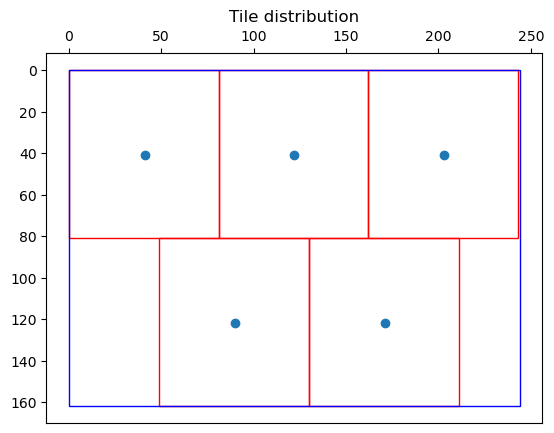

In [11]:
#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.scatter(df00["centre_x"].to_numpy(), df00["centre_y"].to_numpy())

#add rectangle to plot
for index, row in df00.iterrows():
    c_x = row["corner_x"]
    c_y = row["corner_y"]
    
    ax.add_patch(Rectangle((c_x, c_y), row["size_x"], row["size_y"],
             edgecolor = 'red',
             fill=False))

ax.add_patch(Rectangle((0, 0), total_x, total_y,
             edgecolor = 'blue',
             fill=False))

# axis as in image
ax.set_ylim(ax.get_ylim()[::-1])  
ax.xaxis.tick_top() 
ax.yaxis.tick_left()  

#display plot
plt.title("Tile distribution")
plt.show()

## ZARR array

In [12]:
import zarr

In [13]:
store = zarr.DirectoryStore('./data/basic-array.zarr')
chunk_size = np.max(tile_shape)
print(f'Chunk size: {chunk_size},{chunk_size}')
z = zarr.creation.open_array(store=store, mode='a', shape=(total_y, total_x), chunks=(chunk_size,chunk_size), dtype=tile_type)
z

Chunk size: 81,81


<zarr.core.Array (162, 244) uint8>

## Dynamically fill in values

In [14]:
for tile_idx, row in df00.iterrows():
  print(tile_idx)
  tile = skio.imread(f"./data/t0{tile_idx+1}.tif", plugin="tifffile")
  x1 = row["corner_x"]
  x2 = x1+row["size_x"]
  y1 = row["corner_y"]
  y2 = y1+row["size_y"]
  
  print(f"Tile {tile_idx+1}  centre: {row['centre_x']}, {row['centre_y']} goes to: x:[{x1}:{x2}], y:[{y1}:{y2}]")
  z[y1:y2,x1:x2] = tile
  
  

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


0
Tile 1  centre: 41, 41 goes to: x:[0:81], y:[0:81]
1
Tile 2  centre: 122, 41 goes to: x:[81:162], y:[0:81]
2
Tile 3  centre: 203, 41 goes to: x:[162:243], y:[0:81]
3
Tile 4  centre: 90, 122 goes to: x:[49:130], y:[81:162]
4
Tile 5  centre: 171, 122 goes to: x:[130:211], y:[81:162]


## To open in napari

This iamge can be now opened in Napari by drag a drop and using ```napari builtins```

## Changing now to ome-zarr

However, I want to add ome-zarr support. For that I need some minimal metadata, and optionally some resolution levels

For downsampling I will use ```dask-array``` as suggested in [this discussion](https://forum.image.sc/t/creating-an-ome-zarr-dynamically-from-tiles-stored-as-a-series-of-images-list-of-centre-positions-using-python/81657/12?u=camachodejay) 

In [15]:
import dask.array as da

In [16]:
# like numpy.mean, but maintains dtype, helper function
def mean_dtype(arr, **kwargs):
    return np.mean(arr, **kwargs).astype(arr.dtype)

In [17]:
# it is still not quite clear to me why, but we need to rechunk de data at this stage
# if not zarr writting later on will fail
d0 = da.from_zarr(store).rechunk(80,80)
d0

dask.array<rechunk-merge, shape=(162, 244), dtype=uint8, chunksize=(80, 80), chunktype=numpy.ndarray>

In [18]:
d1 = da.coarsen(mean_dtype, d0, {0:2,1:2}).rechunk(40,40)
d1

dask.array<coarsen, shape=(81, 122), dtype=uint8, chunksize=(40, 40), chunktype=numpy.ndarray>

In [19]:
from ome_zarr.io import parse_url
from ome_zarr.writer import write_multiscale
from ome_zarr.writer import write_multiscales_metadata

In [20]:
# I can probably build this programmatically, for the moment I take a shortcut. 
# This assumes an image with full resolution and one downscale by 2x2
coordtfs = [
        [{'type': 'scale', 'scale': [1,1]},
         {'type': 'translation', 'translation': [0, 0]}],
        [{'type': 'scale', 'scale': [2,2]},
         {'type': 'translation', 'translation': [0, 0]}],
        ]
axes = [{'name': 'y', 'type': 'space', 'unit': 'micrometer'},
        {'name': 'x', 'type': 'space', 'unit': 'micrometer'}]

In [21]:
# Open the zarr group manually
path = './data/ome-example.zarr'
store = parse_url(path, mode='w').store
root = zarr.group(store=store)

# Use OME write multiscale; this actually computes the dask arrays but does so
# in a memory-efficient way. ❤️ 🚀
write_multiscale([d0, d1],
        group=root, axes=axes, coordinate_transformations=coordtfs
        )

[]

In [22]:
# add omero metadata: the napari ome-zarr plugin uses this to pass rendering
# options to napari.
root.attrs['omero'] = {
        'channels': [{
                'color': 'ffffff',
                'label': 'blobs',
                'active': True,
                }]
        }


## Open in napari using ome-zarr

Now the date is good for opening in napari using the ```napari-ome-zarr``` plugin: https://github.com/ome/napari-ome-zarr
